# Evaluate water mass properties on the Amundsen Shelf using Pierre's observations

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import cmocean
import cartopy.crs as ccrs
import tqdm
import cartopy.feature as cfeature
import glob
import sys
sys.path.append('/home/users/birgal/')

from nemo_python_git.file_io   import read_dutrieux
from nemo_python_git.utils     import convert_to_teos10, distance_btw_points, closest_point, distance_along_transect
from nemo_python_git.interpolation import interp_latlon_cf
from nemo_python_git.plots     import circumpolar_plot, finished_plot, plot_transect
from nemo_python_git.grid      import transect_coords_from_latlon_waypoints, connect_coord_points
from nemo_python_git.constants import transect_amundsen, land_colour, iceshelf_colour

In [2]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
run_folder    = f'{base_dir}output/ERA5_test4_cont/'
nemo_mesh     = f'{base_dir}bathymetry/mesh_mask-20240305.nc'
nemo_domain   = f'{base_dir}bathymetry/domain_cfg-20240305.nc'

In [3]:
nemo_mesh_ds  = xr.open_dataset(nemo_mesh).isel(time_counter=0)
nemo_mesh_sub = nemo_mesh_ds.isel(x=slice(580, 790), y=slice(200,300))

bathy = xr.where((nemo_mesh_sub.isfdraft > 0) | (nemo_mesh_sub.bathy_metry==0), np.nan, nemo_mesh_sub.bathy_metry)

In [7]:
nemo_mesh_ds.nav_lev.isel(nav_lev=slice(50,60))

<xarray.DataArray 'nav_lev' (nav_lev: 10)>
array([497.68198, 514.27216, 530.8942 , 547.54956, 564.24054, 580.97034,
       597.7431 , 614.5641 , 631.4397 , 648.3777 ], dtype=float32)
Coordinates:
  * nav_lev       (nav_lev) float32 497.7 514.3 530.9 ... 614.6 631.4 648.4
    time_counter  float32 0.0

### Look at transect coming off the shelf


In [ ]:
gridT_files  = glob.glob(f'{run_folder}/*grid_T*')
nemo_ds      = xr.open_dataset(gridT_files[-10]).isel(time_counter=0) # load all thegridT files in the run folder
# nemo_ds = xr.open_mfdataset(gridT_files, engine='netcdf4')
nemo_ds      = nemo_ds.rename({'x_grid_T':'x', 'y_grid_T':'y', 'nav_lon_grid_T':'nav_lon', 'nav_lat_grid_T':'nav_lat', 'deptht':'depth'}) 
nemo_results = nemo_ds #nemo_ds.isel(time_counter=slice(180,None)).mean(dim='time_counter')  # Average time series
    
# load observations:
obs          = read_dutrieux(eos='teos10')
dutrieux_obs = obs.assign({'nav_lon':obs.lon, 'nav_lat':obs.lat}).rename_dims({'lat':'y', 'lon':'x'})
# for zind in tqdm.tqdm(range(obs.depth.size)):
#     obs_temp = interp_latlon_cf(obs.isel(depth=zind), nemo_mesh_sub, method='bilinear')
#     if zind==0:
#         obs_interp=obs_temp
#     else:
#         obs_interp = xr.concat([obs_interp, obs_temp], dim='z')
    
# # vertically average over nemo depth ranges (instead of interpolating)
# for zind in range(nemo_mesh_sub.nav_lev.size):
#     top = nemo_mesh_sub.gdepw_1d.isel(nav_lev=zind) 
#     if zind==nemo_mesh_sub.nav_lev.size-1:
#         bot = nemo_mesh_sub.gdepw_1d.isel(nav_lev=-1) + (nemo_mesh_sub.gdepw_1d.isel(nav_lev=-1) - nemo_mesh_sub.gdept_1d.isel(nav_lev=-1))
#     else:
#         bot = nemo_mesh_sub.gdepw_1d.isel(nav_lev=zind+1) 
#     obs_layer = obs_interp.sel(z=(obs_interp.z >= top)*(obs_interp.z <= bot)).mean(dim='z')
#     if zind==0:
#         obs_vinterp = obs_layer
#     else: 
#         obs_vinterp = xr.concat([obs_vinterp, obs_layer], dim='z')

# calculate bias:

In [4]:
def frames_transect_Amundsen_sims(run_folder, savefig=False, transect_location='shelf_west'):
    import warnings

    gridT_files  = glob.glob(f'{run_folder}/*grid_T*')[0]
    nemo_ds      = xr.open_mfdataset(gridT_files, engine='netcdf4')
    nemo_ds      = nemo_ds.rename({'x_grid_T':'x', 'y_grid_T':'y', 'nav_lon_grid_T':'nav_lon', 'nav_lat_grid_T':'nav_lat', 'deptht':'depth'}) 

    x_sim, y_sim = transect_coords_from_latlon_waypoints(nemo_ds.isel(time_counter=0), transect_amundsen[transect_location], opt_float=False)
    sim_transect = nemo_ds.isel(x=xr.DataArray(x_sim, dims='n'), y=xr.DataArray(y_sim, dims='n'), time_counter=0)
    nemo_mesh_ds = xr.open_dataset('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/mesh_mask-20240305.nc').isel(time_counter=0)
    nemomesh_tr  = nemo_mesh_ds.isel(x=xr.DataArray(x_sim, dims='n'), y=xr.DataArray(y_sim, dims='n')).rename({'nav_lev':'depth'})
    # add tmask, iceshelfmask and depths to the simulation dataset
    sim_transect = sim_transect.assign({'gdept_0':nemomesh_tr.gdept_0, 'tmask':nemomesh_tr.tmask, 'isfdraft':nemomesh_tr.isfdraft})
    sim_distance = distance_along_transect(sim_transect)
    
    for time in nemo_ds.time_counter.isel(time_counter=slice(0,1)):
        sim_transect = nemo_ds.isel(x=xr.DataArray(x_sim, dims='n'), y=xr.DataArray(y_sim, dims='n')).sel(time_counter=time)
        sim_transect = sim_transect.assign({'gdept_0':nemomesh_tr.gdept_0, 'tmask':nemomesh_tr.tmask, 'isfdraft':nemomesh_tr.isfdraft})

        print(time.dt.strftime('%Y-%m-%d').values)

        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                "The input coordinates to pcolormesh are interpreted as cell centers, but "
                "are not monotonically increasing or decreasing. This may lead to "
                "incorrectly calculated cell edges, in which case, please supply explicit "
                "cell edges to pcolormesh.",
                UserWarning,
            )

            fig, ax = plt.subplots(1,2, figsize=(14,4), dpi=125)
            kwagsT    ={'vmin':0.2,'vmax':1,'cmap':cmocean.cm.dense,'label':'Conservative Temp.','ylim':(1300, -20)}
            kwagsS    ={'vmin':34.2,'vmax':34.9,'cmap':cmocean.cm.haline,'label':'Absolute Salinity','ylim':(1300, -20)}
            kwags_mask={'mask_land':True, 'mask_iceshelf':True}
            plot_transect(ax[0], sim_distance, sim_transect, 'thetao', **kwagsT, **kwags_mask)
            plot_transect(ax[1], sim_distance, sim_transect, 'so', **kwagsS, **kwags_mask)   
            ax[0].set_xlabel('Distance (km)')
            ax[1].set_xlabel('Distance (km)')
    
            fig.suptitle(f"{time.dt.strftime('%Y-%m-%d').values}")

        if savefig:
            finished_plot()
    return nemo_ds

So, make the same plot for the year 1979 with adjusted temperature and salinity scales. Looks like a very cold fresh plume sinks. Plot as density to see if it could be sinking, or whether it's actually jsut transported into the region from nearby.

In [5]:
def frames_transect_Amundsen_sims(run_folder, savefig=False, transect_location='shelf_west', add_rho=False, clevels=10,
                                  nemo_mesh='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/mesh_mask-20240305.nc'):
    import warnings
    import gsw

    gridT_files  = glob.glob(f'{run_folder}/*grid_T*')[0]
    nemo_ds      = xr.open_mfdataset(gridT_files, engine='netcdf4').isel(x_grid_T=slice(580, 790), y_grid_T=slice(200,300))
    nemo_ds      = nemo_ds.rename({'x_grid_T':'x', 'y_grid_T':'y', 'nav_lon_grid_T':'nav_lon', 'nav_lat_grid_T':'nav_lat', 'deptht':'depth'})
    if add_rho:
        sigma        = gsw.density.sigma0(nemo_ds.so, nemo_ds.thetao)
        nemo_ds      = nemo_ds.assign({'sigma0':sigma})
        contour_var  = 'sigma0'
    else:
        contour_var  = '' 

    x_sim, y_sim = transect_coords_from_latlon_waypoints(nemo_ds.isel(time_counter=0), transect_amundsen[transect_location], opt_float=False)
    sim_transect = nemo_ds.isel(x=xr.DataArray(x_sim, dims='n'), y=xr.DataArray(y_sim, dims='n'), time_counter=0)
    nemo_mesh_ds = xr.open_dataset(nemo_mesh).isel(time_counter=0,x=slice(580, 790),y=slice(200,300))
    nemomesh_tr  = nemo_mesh_ds.isel(x=xr.DataArray(x_sim, dims='n'), y=xr.DataArray(y_sim, dims='n')).rename({'nav_lev':'depth'})
    # add tmask, iceshelfmask and depths to the simulation dataset
    sim_transect = sim_transect.assign({'gdept_0':nemomesh_tr.gdept_0, 'tmask':nemomesh_tr.tmask, 'isfdraft':nemomesh_tr.isfdraft})
    sim_distance = distance_along_transect(sim_transect)
    
    for time in nemo_ds.time_counter.isel(time_counter=slice(0,1)):
        sim_transect = nemo_ds.isel(x=xr.DataArray(x_sim, dims='n'), y=xr.DataArray(y_sim, dims='n')).sel(time_counter=time)
        sim_transect = sim_transect.assign({'gdept_0':nemomesh_tr.gdept_0, 'tmask':nemomesh_tr.tmask, 'isfdraft':nemomesh_tr.isfdraft})

        print(time.dt.strftime('%Y-%m-%d').values)

        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                "The input coordinates to pcolormesh are interpreted as cell centers, but "
                "are not monotonically increasing or decreasing. This may lead to "
                "incorrectly calculated cell edges, in which case, please supply explicit "
                "cell edges to pcolormesh.",
                UserWarning,
            )

            fig, ax = plt.subplots(1,2, figsize=(14,4), dpi=125)
            kwagsT    ={'vmin':0.2,'vmax':1,'cmap':cmocean.cm.dense,'label':'Conservative Temp.','ylim':(1300, -20)}
            kwagsS    ={'vmin':34.3,'vmax':34.9,'cmap':cmocean.cm.haline,'label':'Absolute Salinity','ylim':(1300, -20)}
            kwagsrho  = {'clevels':clevels, 'contour_var':contour_var}
            kwags_mask={'mask_land':True, 'mask_iceshelf':True}
            plot_transect(ax[0], sim_distance, sim_transect, 'thetao', **kwagsT, **kwagsrho, **kwags_mask)
            plot_transect(ax[1], sim_distance, sim_transect, 'so', **kwagsS, **kwagsrho, **kwags_mask)   
            ax[0].set_xlabel('Distance (km)')
            ax[1].set_xlabel('Distance (km)')
    
            fig.suptitle(f"{time.dt.strftime('%Y-%m-%d').values}")

        if savefig:
            finished_plot()
    return 

In [4]:
from nemo_python_git.projects.evaluation import frames_transect_Amundsen_sims

1979-01-16


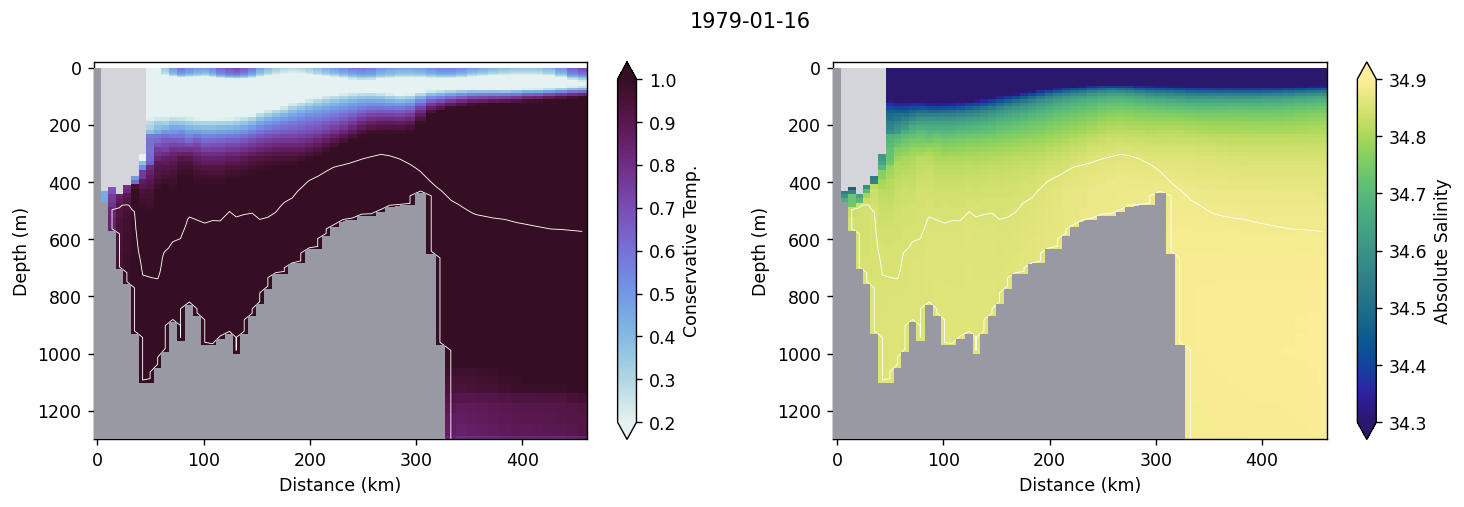

In [7]:
frames_transect_Amundsen_sims('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/ERA5_test4/', savefig=False, 
                              add_rho=True, clevels=[27.79])

1979-01-01


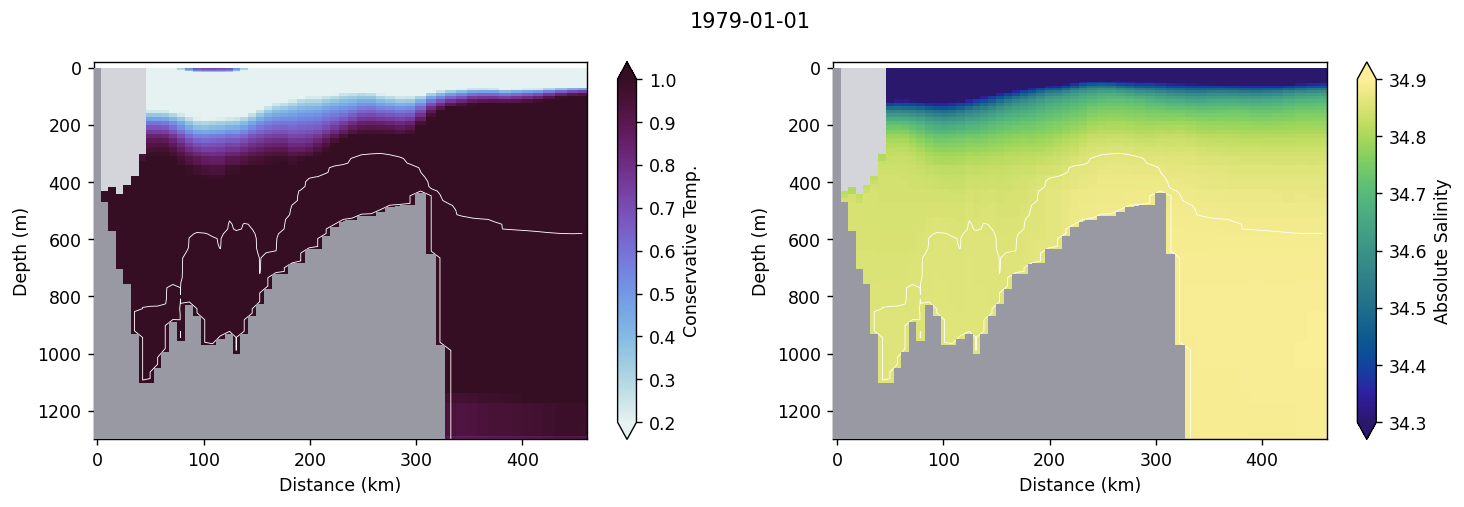

In [8]:
frames_transect_Amundsen_sims('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/ERA5_test5/new_ICs_w_icb/', savefig=False, 
                              add_rho=True, clevels=[27.79])

/tmp/ipykernel_540/1580108306.py:17: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cm1 = ax.pcolormesh(distance, depth, data_transect[var_name].values, **kwags)
/tmp/ipykernel_540/1580108306.py:26: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(distance, depth, land_mask, rasterized=True, cmap=cl.ListedColormap(land_colour), zorder=3)
/tmp/ipykernel_540/1580108306.py:33: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, 

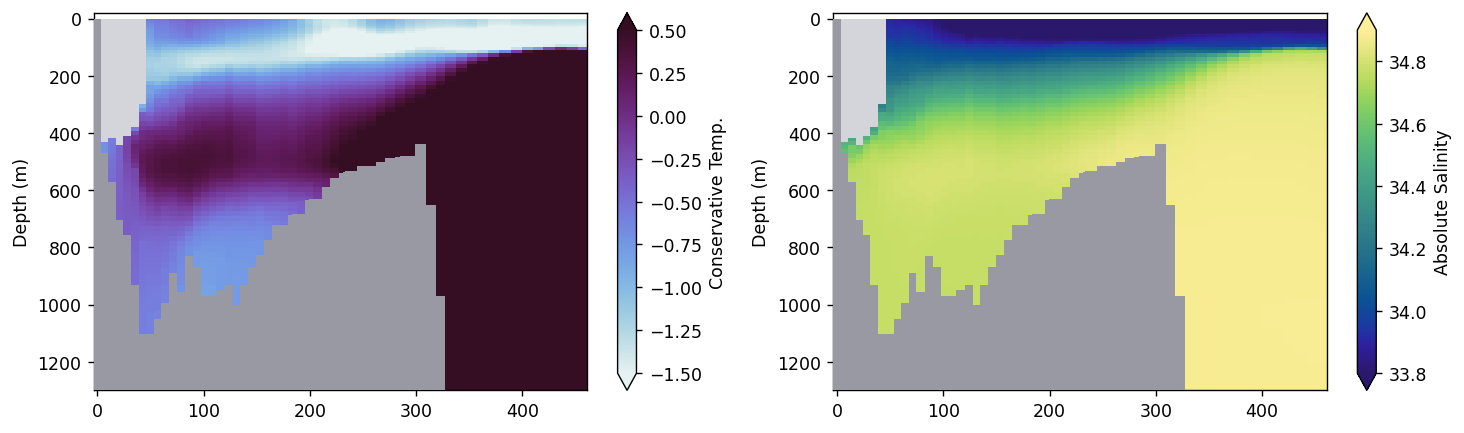

In [26]:
fig, ax = plt.subplots(1,2, figsize=(14,4), dpi=125)
kwagsT    ={'vmin':-1.5,'vmax':0.5,'cmap':cmocean.cm.dense,'label':'Conservative Temp.','ylim':(1300, -20)}
kwagsS    ={'vmin':33.8,'vmax':34.9,'cmap':cmocean.cm.haline,'label':'Absolute Salinity','ylim':(1300, -20)}
kwags_mask={'mask_land':True, 'mask_iceshelf':True}
plot_transect(ax[0], sim_distance_mid, sim_transect_mid, 'thetao', **kwagsT, **kwags_mask)
plot_transect(ax[1], sim_distance_mid, sim_transect_mid, 'so', **kwagsS, **kwags_mask) 

In [40]:
x_obs, y_obs      = transect_coords_from_latlon_waypoints(dutrieux_obs, transect_amundsen['shelf_west'], opt_float=False)    
# subset the datasets and nemo_mesh to the coordinates of the transect:
obs_transect_west = dutrieux_obs.isel(x=xr.DataArray(x_obs, dims='n'), y=xr.DataArray(y_obs, dims='n'))

# x_obs, y_obs      = transect_coords_from_latlon_waypoints(dutrieux_obs, transect_amundsen['shelf_mid'], opt_float=False)    
# obs_transect_mid  = dutrieux_obs.isel(x=xr.DataArray(x_obs, dims='n'), y=xr.DataArray(y_obs, dims='n'))

# x_obs, y_obs      = transect_coords_from_latlon_waypoints(dutrieux_obs, transect_amundsen['shelf_east'], opt_float=False)    
# obs_transect_east = dutrieux_obs.isel(x=xr.DataArray(x_obs, dims='n'), y=xr.DataArray(y_obs, dims='n'))

# x_obs, y_obs      = transect_coords_from_latlon_waypoints(dutrieux_obs, transect_amundsen['shelf_edge'], opt_float=False)    
# obs_transect_edge = dutrieux_obs.isel(x=xr.DataArray(x_obs, dims='n'), y=xr.DataArray(y_obs, dims='n'))

# x_obs, y_obs        = transect_coords_from_latlon_waypoints(dutrieux_obs, transect_amundsen['Getz_left'], opt_float=False)    
# obs_transect_getzl  = dutrieux_obs.isel(x=xr.DataArray(x_obs, dims='n'), y=xr.DataArray(y_obs, dims='n'))

# x_obs, y_obs        = transect_coords_from_latlon_waypoints(dutrieux_obs, transect_amundsen['Getz_right'], opt_float=False)    
# obs_transect_getzr  = dutrieux_obs.isel(x=xr.DataArray(x_obs, dims='n'), y=xr.DataArray(y_obs, dims='n'))

# x_obs, y_obs        = transect_coords_from_latlon_waypoints(dutrieux_obs, transect_amundsen['Dotson'], opt_float=False)   
# obs_transect_dotson = dutrieux_obs.isel(x=xr.DataArray(x_obs, dims='n'), y=xr.DataArray(y_obs, dims='n'))

# x_obs, y_obs          = transect_coords_from_latlon_waypoints(dutrieux_obs, transect_amundsen['PI_trough'], opt_float=False)   
# obs_transect_PItrough = dutrieux_obs.isel(x=xr.DataArray(x_obs, dims='n'), y=xr.DataArray(y_obs, dims='n'))

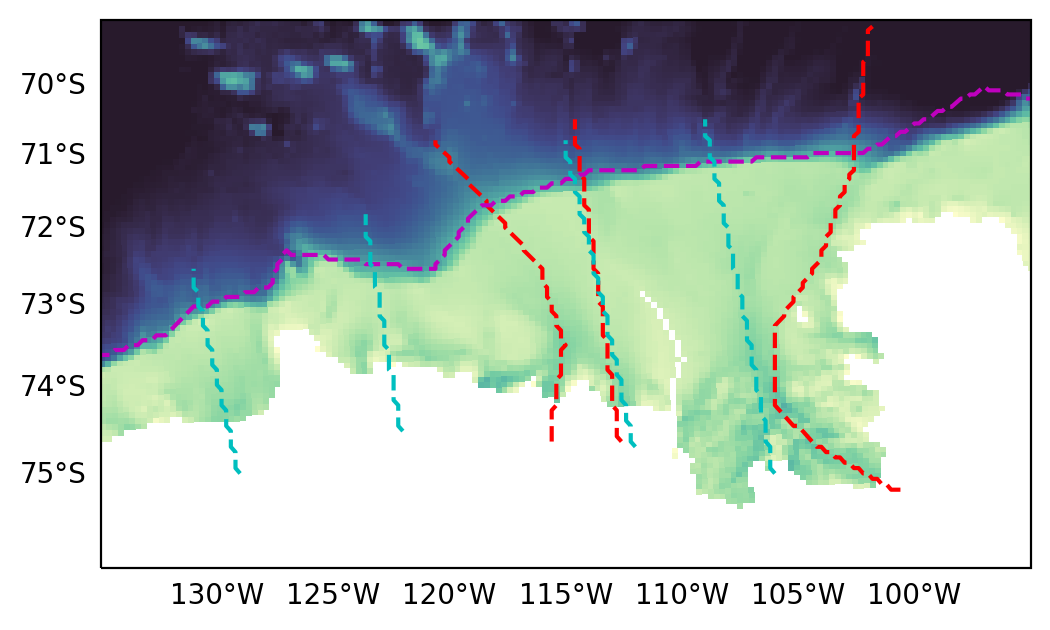

In [8]:
# now do the same for a transect in the simulation

nemo_mesh_ds = xr.open_dataset(nemo_mesh)
mesh_sub     = nemo_mesh_ds.isel(x=slice(450, 900), y=slice(130,350), time_counter=0)

fig, ax = plt.subplots(1,1, figsize=(6,4), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)}, dpi=200)

img1 = ax.pcolormesh(nemo_mesh_sub.nav_lon.values, nemo_mesh_sub.nav_lat.values, 
                     bathy.values, transform=ccrs.PlateCarree(),rasterized=True,cmap=cmocean.cm.deep,vmin=0,vmax=4000)

# ax.plot(sim_transect.nav_lon.values, sim_transect.nav_lat.values, '-r', transform=ccrs.PlateCarree())
ax.plot(obs_transect_west.nav_lon.values, obs_transect_west.nav_lat.values, '--r', transform=ccrs.PlateCarree())
ax.plot(obs_transect_mid.nav_lon.values , obs_transect_mid.nav_lat.values , '--r', transform=ccrs.PlateCarree())
ax.plot(obs_transect_east.nav_lon.values, obs_transect_east.nav_lat.values, '--r', transform=ccrs.PlateCarree())
ax.plot(obs_transect_edge.nav_lon.values, obs_transect_edge.nav_lat.values, '--m', transform=ccrs.PlateCarree())

ax.plot(obs_transect_getzl.nav_lon.values, obs_transect_getzl.nav_lat.values, '--c', transform=ccrs.PlateCarree())
ax.plot(obs_transect_getzr.nav_lon.values , obs_transect_getzr.nav_lat.values , '--c', transform=ccrs.PlateCarree())
ax.plot(obs_transect_dotson.nav_lon.values, obs_transect_dotson.nav_lat.values, '--c', transform=ccrs.PlateCarree())
ax.plot(obs_transect_PItrough.nav_lon.values, obs_transect_PItrough.nav_lat.values, '--c', transform=ccrs.PlateCarree())

ax.set_extent([-95, -135, -76, -69], ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True);
gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;

In [ ]:
# Next up! do average vertical profiles in regions and variability compared to obs